In [2]:
import importlib
import io
import os
import re
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

# If a function was added to the package, I have to reload the specific module rather than the whole package
importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

<Figure size 100x100 with 0 Axes>

In [4]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

df = lcwgsus.read_vcf('results/chip/vcf/chip_genotype.vcf.gz')

kinship = pd.read_csv( "results/chip/qc/PCs/chip_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')

snp = pd.merge(snp, df[['ID', 'ref', 'alt', 'pos']], left_on = 'rsid', right_on = 'ID')
snp = snp.drop(columns = ['alleleA', 'alleleB', 'position']).rename(columns = {'ref': 'alleleA', 'alt': 'alleleB', 'pos': 'position'})

In [6]:
snp_missing = 0.05
snp_hwe = 1e-6
sample_missing = 0.05
heterozygosity_nstd = 3

drop_history = {}
num = snp.shape[0]
drop_history['original'] = num

snp = snp[~snp['chromosome'].isin(['MT', 'NA'])]
drop_history['drop_non-autosome'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < 0.2]
drop_history['drop_snp_missing_0.2'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['HW_exact_p_value'] > snp_hwe]
drop_history['drop_snp_hwe_1e-6'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < snp_missing]
drop_history['drop_snp_missing_0.05'] = num - snp.shape[0]
num = snp.shape[0]

# sample = sample[sample['missing_proportion'] < sample_missing]
# std = sample['heterozygous_proportion'].std()
# mean = sample['heterozygous_proportion'].mean()
# sample = sample[(sample['heterozygous_proportion'] > mean - heterozygosity_nstd*std) & (sample['heterozygous_proportion'] < mean + heterozygosity_nstd*std)]

In [7]:
chromosomes = [i for i in range(1,23)]
oneKGmafs = ["/well/band/users/rbx225/recyclable_files/AFs/oneKG_MAFs/oneKG_AF_AFR_chr" + str(i) + ".txt" for i in chromosomes]
oneKGaf = lcwgsus.multi_read_af(chromosomes, oneKGmafs)
oneKGaf = oneKGaf.rename(columns = {'MAF': 'prop'})
oneKGaf['prop'] = np.where(oneKGaf['prop'] > 0.5, 1 - oneKGaf['prop'], oneKGaf['prop'])

GGVPmafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
GGVPaf = lcwgsus.multi_read_af(chromosomes, GGVPmafs)
GGVPaf = GGVPaf.rename(columns = {'MAF': 'prop'})
GGVPaf['prop'] = np.where(GGVPaf['prop'] > 0.5, 1 - GGVPaf['prop'], GGVPaf['prop'])
af = pd.merge(oneKGaf, GGVPaf, on = ['chr', 'pos', 'ref', 'alt'], how = 'outer')
af['prop'] = af['prop_x'].combine_first(af['prop_y'])
af = af.drop(columns = ['prop_x', 'prop_y'])

In [8]:
chip_af = snp[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
chip_af = chip_af.rename(columns = {'chromosome': 'chr', 'position': 'pos', 'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
chip_af = chip_af[chip_af['chr'].isin([str(i) for i in range(1,23)])]
chip_af['chr'] = chip_af['chr'].astype(int)
chip_af['ref'] = chip_af['ref'].astype(str)
chip_af['alt'] = chip_af['alt'].astype(str)

def fill_prop(r):
    if pd.isna(r['prop_y']):
        r['prop_y'] = r['prop_x']
    return r

final = pd.merge(chip_af, af, on = ['chr', 'pos', 'ref', 'alt'], how = 'left')
final = final.apply(fill_prop, axis = 1)

9.777832454519763e-01

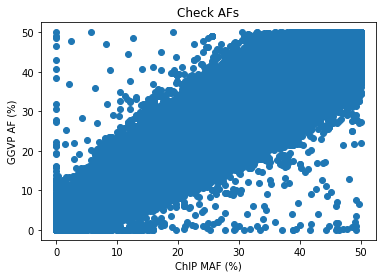

In [51]:
# This is GGVP+oneKG vs chip
lcwgsus.plot_afs(chip_af, af, save_fig = False)

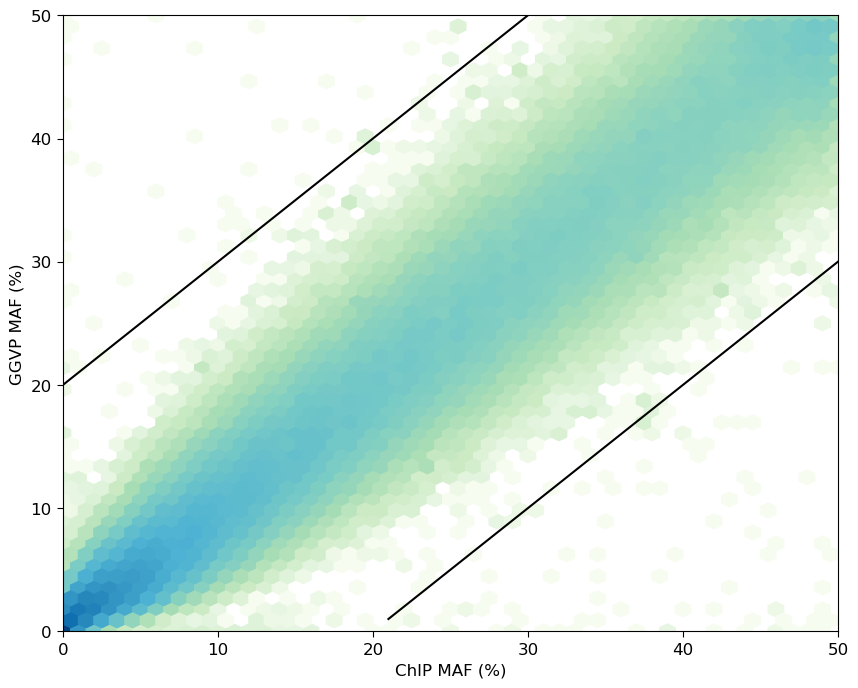

In [10]:
# res = final[(final['prop_y'] != 1) & (final['prop_y'] != 0)]
# delta = ((res['prop_x'] - res['prop_y'])**2/(res['prop_y']*(1-res['prop_y']))).sum()/(2*res.shape[0])

# nstd = 4

y = np.arange(1,51)/100

# xp = nstd*np.sqrt(y*(1-y)*delta) + y+0.05
# xm = -nstd*np.sqrt(y*(1-y)*delta) + y-0.02

xp = y+0.2
xm = y-0.2

plt.figure(figsize=(10, 8))
plt.hexbin(final['prop_x']*100, final['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
# plt.title('AFs BEFORE filtering')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

plt.savefig('graphs/paper/sf1.png', dpi = 300)

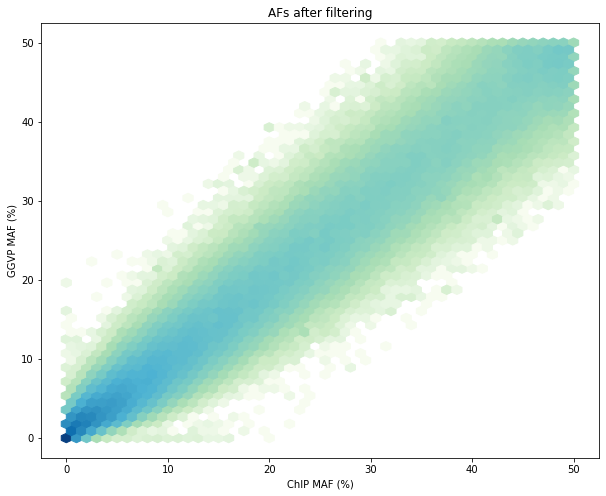

In [53]:
# filtered = res[((res['prop_x'] - res['prop_y']-0.05)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta)) & 
#           ((-res['prop_x'] + res['prop_y']+0.02)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta))]
# This removed 80,000 sites

filtered = final[abs(final['prop_x'] - final['prop_y']) <= 0.2]
drop_history['filter_maf'] = num - filtered.shape[0]
num = filtered.shape[0]

plt.figure(figsize=(10, 8))
plt.hexbin(filtered['prop_x']*100, filtered['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs after filtering')
plt.show()

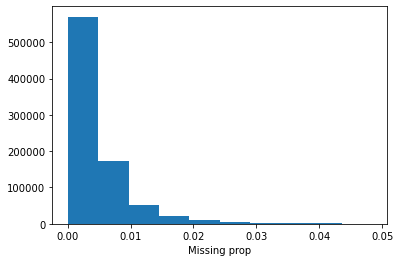

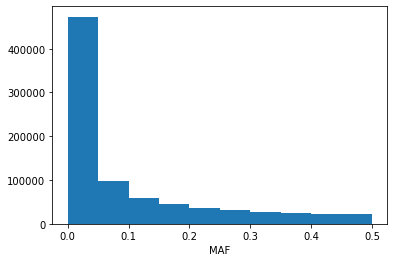

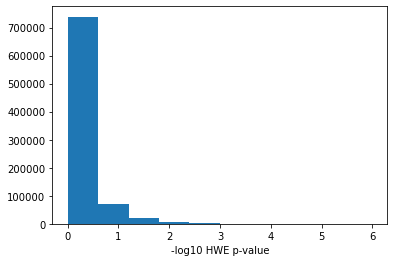

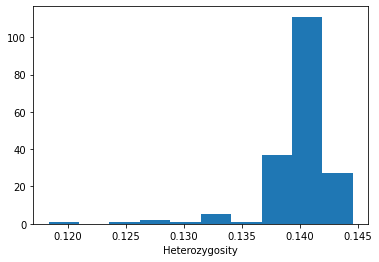

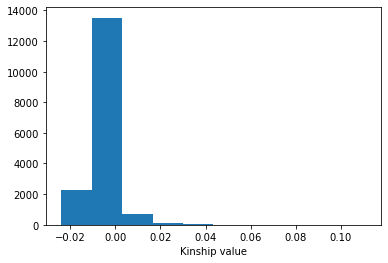

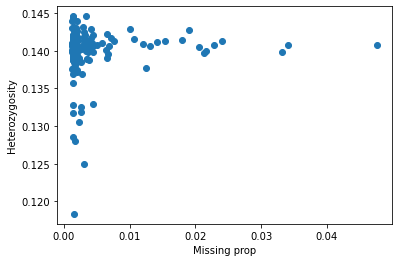

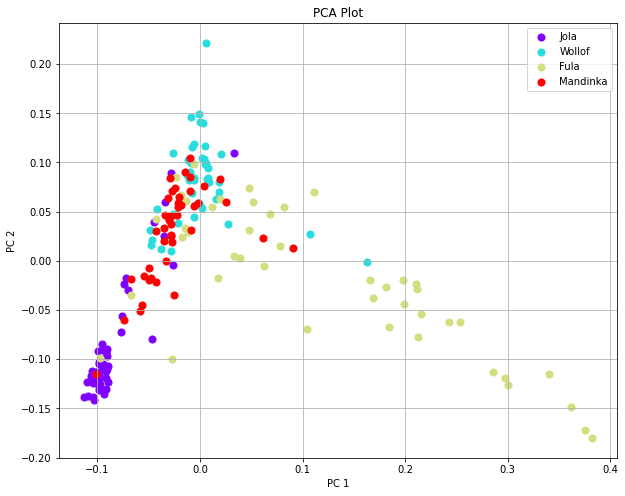

<Figure size 720x576 with 0 Axes>

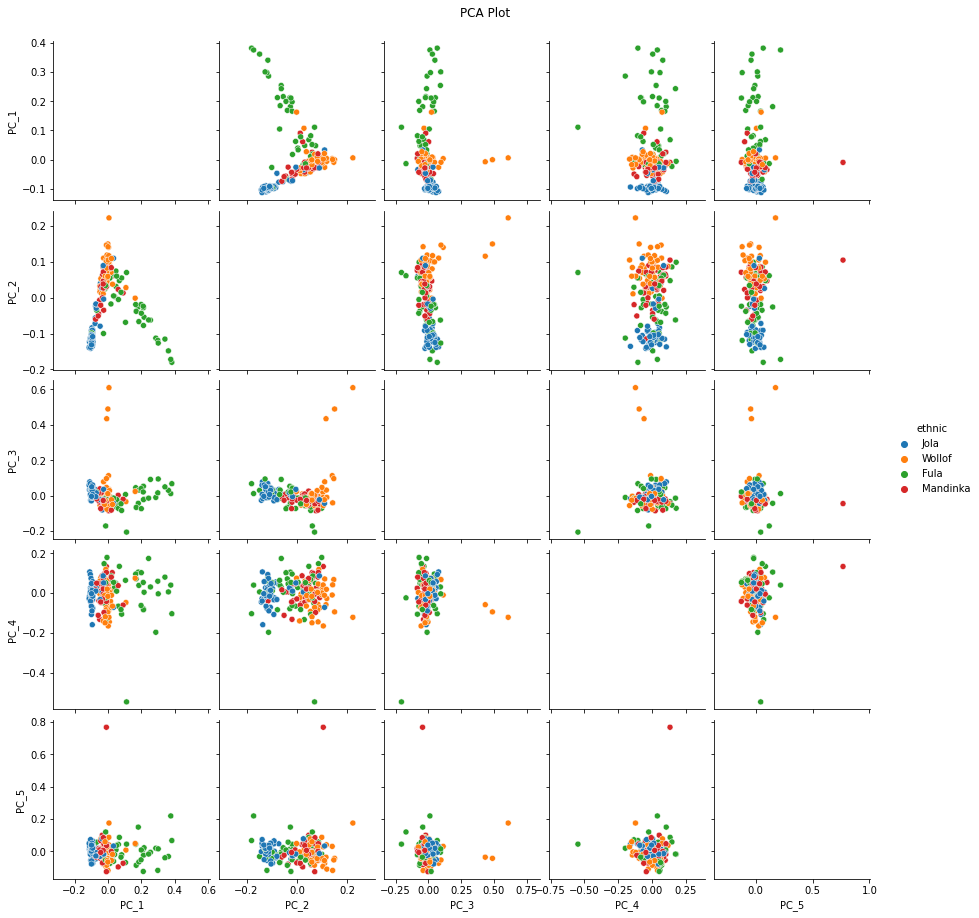

In [112]:
plt.hist(snp['missing_proportion'])
plt.xlabel('Missing prop')
plt.show()

plt.hist(snp['minor_allele_frequency'])
plt.xlabel('MAF')
plt.show()

plt.hist(-np.log10(snp['HW_exact_p_value']))
plt.xlabel('-log10 HWE p-value')
plt.show()

plt.hist(sample['heterozygous_proportion'])
plt.xlabel('Heterozygosity')
plt.show()

plt.hist(kinship[kinship['sample_1'] != kinship['sample_2']]['value'])
plt.xlabel('Kinship value')
plt.show()

plt.scatter(sample['missing_proportion'], sample['heterozygous_proportion'])
plt.xlabel('Missing prop')
plt.ylabel('Heterozygosity')
plt.show()

lcwgsus.plot_pc(PC)

lcwgsus.plot.plot_pc(PC, 5)

In [70]:
drop_history['original'] = 872149
drop_history['drop_non-autosome'] = 872149 - 837937
drop_history['final'] = filtered.shape[0]
drop_history

{'original': 872149,
 'drop_non-autosome': 34212,
 'drop_snp_missing_0.2': 854,
 'drop_snp_hwe_1e-6': 365,
 'drop_snp_missing_0.05': 1,
 'filter_maf': 189,
 'final': 836528}

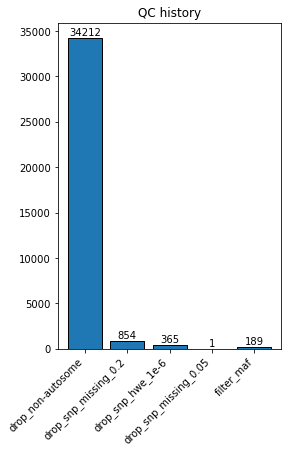

In [79]:
plt.figure(figsize = (4,6))
x = list(drop_history.keys())[1:-1]
y = list(drop_history.values())[1:-1]
plt.bar(x,y, ec='black')
for i, v in enumerate(y):
    plt.text(i, v + 300, str(v), ha='center')
plt.xticks(rotation=45, ha = 'right')
plt.title('QC history')
plt.show()

In [ ]:
db2 = sqlite3.connect( "results/chip/qc/chip.qc.gavin.sqlite" )
PC2 = pd.read_sql_query( "SELECT * FROM PCsView", db2 )
PC2 = PC2[PC2['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC2 = PC2.merge(ethnic, on = 'sample_id', how = 'left')
plot = sns.pairplot(PC2[['PC_' + str(i) for i in range(1,6)] + ['ethnic']], hue="ethnic", diag_kind="kde", diag_kws={"linewidth": 0, "shade": False})
plot.fig.suptitle('Removing 2 samples', y = 1.02)
plt.show()

In [67]:
chip_filtered = filtered.drop(columns = ['ref', 'alt', 'prop_x', 'prop_y'])
chip_filtered.to_csv('results/chip/vcf/retain_sites.tsv', sep = '\t', header = False, index = False)
# samples_removed = pd.DataFrame({'samples': ['GAM370894', 'GAM916387', 'GAM654203']}) 
# samples_removed.to_csv('results/chip/vcf/drop_samples.tsv', sep = '\t', header = False, index = False)